# Imports

In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import re
import warnings

import matplotlib.pyplot as plt
import pandas as pd

from controller import Controller
from data_audit import DataAudit
from nonparamtests import calculate_ami, calculate_kruskal
from reporting import correlation_report
from population_flow import population_flow

In [3]:
c = Controller('i01')

# Load data

In [4]:
filepath = fr'{c.get_path_data_prepared()}/01_df_train_val_test.pkl'
df_train_val_test = pd.read_pickle(filepath)

df_train = df_train_val_test.query('TRAIN_VAL_TEST_SPLIT == "Train"')
print(f'{df_train.shape=}')
df_val = df_train_val_test.query('TRAIN_VAL_TEST_SPLIT == "Validation"')
print(f'{df_val.shape=}')
df_test = df_train_val_test.query('TRAIN_VAL_TEST_SPLIT == "Test"')
print(f'{df_test.shape=}')

df_train_val_test

df_train.shape=(38655, 114)
df_val.shape=(4295, 114)
df_test.shape=(4773, 114)


,ACN_NUM_ACN,TIME_DATE,TIME_1_LOCAL_TIME_OF_DAY,PLACE_LOCALE_REFERENCE,PLACE_1_STATE_REFERENCE,PLACE_2_RELATIVE_POSITION_ANGLE_RADIAL,PLACE_3_RELATIVE_POSITION_DISTANCE_NAUTICAL_MILES,PLACE_4_ALTITUDE_AGL_SINGLE_VALUE,PLACE_5_ALTITUDE_MSL_SINGLE_VALUE,ENVIRONMENT_FLIGHT_CONDITIONS,...,ASSESSMENTS_CONTRIBUTING_FACTORS_SITUATIONS,ASSESSMENTS_1_PRIMARY_PROBLEM,REPORT_1_NARRATIVE,REPORT_1_1_CALLBACK,REPORT_2_NARRATIVE,REPORT_2_1_CALLBACK,REPORT_1_2_SYNOPSIS,TRAIN_VAL_TEST_SPLIT,EVENT_RISK,EVENT_RISK_STR
0,1574675,201808,0601-1200,SNA.Airport,CA,NaN,NaN,NaN,5000.0,NaN,...,Human Factors,Human Factors,SNA RNP-Z to Runway 20R. The FMC was properly ...,NaN,We were cleared for the RNP RNAV Z 20R Approac...,NaN,B737-700 flight crew reported failing to make ...,Train,2,Medium risk
1,1224894,201412,0601-1200,MSY.Airport,LA,NaN,NaN,1000.0,NaN,VMC,...,Human Factors,Human Factors,On base to final turn to runway 1 in MSY at ap...,NaN,NaN,NaN,Captain reports sighting of a drone at 1;000 f...,Train,0,Low risk
2,1134202,201312,1201-1800,ZZZ.ARTCC,US,NaN,NaN,NaN,2600.0,IMC,...,Human Factors; Aircraft; Procedure; Weather,Aircraft,I climbed to my filed altitude of 5;000 FT; an...,NaN,NaN,NaN,SR22 pilot became disoriented on approach in I...,Train,3,Moderately high risk
3,1222074,201411,1201-1800,CWA.Airport,WI,NaN,20.0,NaN,4000.0,NaN,...,Aircraft,Aircraft,I had my pitot heat checked prior to winter an...,NaN,NaN,NaN,BE58 pilot experiences pitot heat failure desc...,Train,2,Medium risk
4,1733019,202003,1801-2400,ZDV.ARTCC,CO,NaN,NaN,NaN,32000.0,NaN,...,Airspace Structure; Weather,Weather,At 32000 ft. just north of PUB the aircraft ex...,NaN,NaN,NaN,B737 First Officer reported unexpected moderat...,Train,3,Moderately high risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47718,1341108,201603,0601-1200,ZZZ.Airport,US,NaN,NaN,NaN,NaN,IMC,...,Company Policy; Human Factors,Human Factors,We did an originator out of ZZZ and had a main...,NaN,[Report narrative contained no additional info...,NaN,CRJ-900 flight crew reported being dispatched ...,Test,3,Moderately high risk
47719,1087474,201305,1201-1800,PHX.Airport,AZ,NaN,NaN,NaN,8000.0,VMC,...,Aircraft; Human Factors; Procedure,Ambiguous,PHX takeoff Runway 25R flaps 5. CLEARANCE: MAX...,NaN,There was an Airbus that departed before us an...,NaN,CE750 flight crew departing PHX Runway 25R on ...,Test,3,Moderately high risk
47720,1756601,202008,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,Environment - Non Weather Related; Company Pol...,Company Policy,I was scheduled to complete the one day traini...,NaN,NaN,NaN,Air carrier First Officer reported that re-qua...,Test,0,Low risk
47721,1102938,201307,0601-1200,MEM.Airport,TN,NaN,NaN,NaN,NaN,VMC,...,Airspace Structure; Chart Or Publication; Proc...,Human Factors,We departed Runway 36C in MEM via the GOETZ TW...,NaN,NaN,NaN,On initial climb out via the GOETZ RNAV SID fr...,Test,2,Medium risk


In [5]:
df_train_val_test['EVENT_RISK_STR'].value_counts()

Medium risk               16519
Low risk                  10754
High risk                  7349
Moderately high risk       7346
Moderately medium risk     5755
Name: EVENT_RISK_STR, dtype: int64

In [6]:
filepath = fr'{c.get_path_iteration()}/{c.iteration}_ss.pkl'
with open(filepath, 'rb') as f:
    selection_set = pickle.load(f)
len(selection_set)

110

# Population Flows

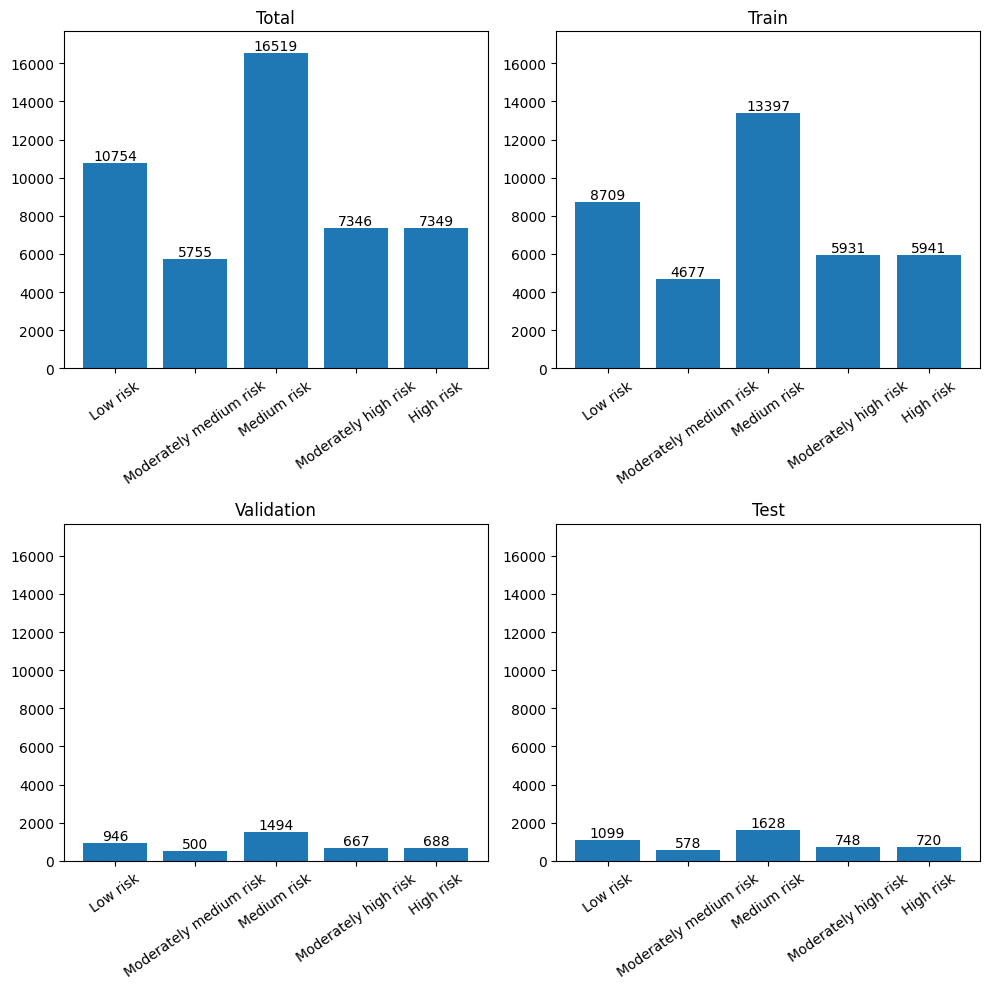

In [7]:
class_order = ['Low risk', 'Moderately medium risk', 'Medium risk', 'Moderately high risk', 'High risk']
population_flow(df_train_val_test, 'EVENT_RISK_STR', y_axis='# Total', split='TRAIN_VAL_TEST_SPLIT', class_order=class_order)

# Data audit

For each column in the dataframe, perform univariate analysis.

In [8]:
data_audit_full = DataAudit()
data_audit_full.fit(df_train_val_test, df_train_val_test['EVENT_RISK'], selection_set=selection_set)
data_audit_full.view_summary()

100%|██████████| 110/110 [00:02<00:00, 48.82it/s, Processing REPORT_1_2_SYNOPSIS]                                                


,VARIABLE,LABEL,TYPE,% UNIQUE,% MISSING,MEAN,STD,MIN,50%,MAX,COMMENT
0,ACN_NUM_ACN,.,int64,1.0000,0.0000,1429583.833812,273143.371337,986560,1429176,1881918.0,.
1,TIME_DATE,.,int64,0.0023,0.0000,201665.241854,296.40195,201201,201703,202203.0,.
2,TIME_1_LOCAL_TIME_OF_DAY,.,object,0.0001,0.1035,<NA>,<NA>,<NA>,<NA>,<NA>,.
3,PLACE_LOCALE_REFERENCE,.,object,0.0492,0.0603,<NA>,<NA>,<NA>,<NA>,<NA>,.
4,PLACE_1_STATE_REFERENCE,.,object,0.0015,0.0603,<NA>,<NA>,<NA>,<NA>,<NA>,.
...,...,...,...,...,...,...,...,...,...,...,...
105,REPORT_1_NARRATIVE,.,object,0.9998,0.0000,<NA>,<NA>,<NA>,<NA>,<NA>,.
106,REPORT_1_1_CALLBACK,.,object,0.9930,0.9699,<NA>,<NA>,<NA>,<NA>,<NA>,.
107,REPORT_2_NARRATIVE,.,object,0.7561,0.7647,<NA>,<NA>,<NA>,<NA>,<NA>,.
108,REPORT_2_1_CALLBACK,.,object,1.0000,0.9982,<NA>,<NA>,<NA>,<NA>,<NA>,.


In [9]:
data_audit_train = DataAudit()
data_audit_train.fit(df_train, df_train['EVENT_RISK'], selection_set=selection_set)
data_audit_train.view_summary()

100%|██████████| 110/110 [00:01<00:00, 56.00it/s, Processing REPORT_1_2_SYNOPSIS]                                                


,VARIABLE,LABEL,TYPE,% UNIQUE,% MISSING,MEAN,STD,MIN,50%,MAX,COMMENT
0,ACN_NUM_ACN,.,int64,1.0000,0.0000,1428314.543423,273213.873552,986560,1428078,1881918.0,.
1,TIME_DATE,.,int64,0.0029,0.0000,201663.858026,296.471514,201201,201702,202203.0,.
2,TIME_1_LOCAL_TIME_OF_DAY,.,object,0.0001,0.1035,<NA>,<NA>,<NA>,<NA>,<NA>,.
3,PLACE_LOCALE_REFERENCE,.,object,0.0555,0.0587,<NA>,<NA>,<NA>,<NA>,<NA>,.
4,PLACE_1_STATE_REFERENCE,.,object,0.0019,0.0586,<NA>,<NA>,<NA>,<NA>,<NA>,.
...,...,...,...,...,...,...,...,...,...,...,...
105,REPORT_1_NARRATIVE,.,object,0.9999,0.0000,<NA>,<NA>,<NA>,<NA>,<NA>,.
106,REPORT_1_1_CALLBACK,.,object,0.9941,0.9694,<NA>,<NA>,<NA>,<NA>,<NA>,.
107,REPORT_2_NARRATIVE,.,object,0.7599,0.7643,<NA>,<NA>,<NA>,<NA>,<NA>,.
108,REPORT_2_1_CALLBACK,.,object,1.0000,0.9984,<NA>,<NA>,<NA>,<NA>,<NA>,.


In [10]:
numeric_features = df_train[selection_set].select_dtypes('object').columns
amis = calculate_ami(df_train, numeric_features, df_train['EVENT_RISK'])
amis

TIME_1_LOCAL_TIME_OF_DAY                     0.011183
PLACE_LOCALE_REFERENCE                       0.020424
PLACE_1_STATE_REFERENCE                      0.022188
ENVIRONMENT_FLIGHT_CONDITIONS                0.027898
ENVIRONMENT_1_WEATHER_ELEMENTS_VISIBILITY    0.010362
                                               ...   
REPORT_1_NARRATIVE                           0.000030
REPORT_1_1_CALLBACK                          0.005068
REPORT_2_NARRATIVE                           0.005447
REPORT_2_1_CALLBACK                          0.000334
REPORT_1_2_SYNOPSIS                          0.000126
Name: AMI, Length: 98, dtype: float64

In [11]:
numeric_features = df_train[selection_set].select_dtypes('number').columns
kruskal_pvalues = calculate_kruskal(df_train, numeric_features, df_train['EVENT_RISK'])
kruskal_pvalues

ACN_NUM_ACN                                                 1.000000e+00
TIME_DATE                                                   1.364511e-01
PLACE_2_RELATIVE_POSITION_ANGLE_RADIAL                      3.759212e-27
PLACE_3_RELATIVE_POSITION_DISTANCE_NAUTICAL_MILES           7.074898e-34
PLACE_4_ALTITUDE_AGL_SINGLE_VALUE                           3.942849e-35
PLACE_5_ALTITUDE_MSL_SINGLE_VALUE                          6.994266e-119
AIRCRAFT_1_4_CREW_SIZE                                      1.266913e-05
AIRCRAFT_1_19_NUMBER_OF_SEATS_NUMBER                        2.250133e-01
AIRCRAFT_1_20_PASSENGERS_ON_BOARD_NUMBER                    1.055020e-01
AIRCRAFT_1_21_CREW_SIZE_FLIGHT_ATTENDANT_NUMBER_OF_CREW     5.009841e-05
AIRCRAFT_2_4_CREW_SIZE                                      1.030534e-05
PERSON_1_10_ASRS_REPORT_NUMBER_ACCESSION_NUMBER             1.000000e+00
Name: KRUSKAL, dtype: float64

In [12]:
data_audit_train.extend_summary([amis, kruskal_pvalues])
data_audit_train.view_summary()

,VARIABLE,LABEL,TYPE,% UNIQUE,% MISSING,MEAN,STD,MIN,50%,MAX,COMMENT,AMI,KRUSKAL
0,ACN_NUM_ACN,.,int64,1.0000,0.0000,1428314.543423,273213.873552,986560,1428078,1881918.0,.,NaN,1.000000
1,TIME_DATE,.,int64,0.0029,0.0000,201663.858026,296.471514,201201,201702,202203.0,.,NaN,0.136451
2,TIME_1_LOCAL_TIME_OF_DAY,.,object,0.0001,0.1035,<NA>,<NA>,<NA>,<NA>,<NA>,.,0.011183,NaN
3,PLACE_LOCALE_REFERENCE,.,object,0.0555,0.0587,<NA>,<NA>,<NA>,<NA>,<NA>,.,0.020424,NaN
4,PLACE_1_STATE_REFERENCE,.,object,0.0019,0.0586,<NA>,<NA>,<NA>,<NA>,<NA>,.,0.022188,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,REPORT_1_NARRATIVE,.,object,0.9999,0.0000,<NA>,<NA>,<NA>,<NA>,<NA>,.,0.000030,NaN
106,REPORT_1_1_CALLBACK,.,object,0.9941,0.9694,<NA>,<NA>,<NA>,<NA>,<NA>,.,0.005068,NaN
107,REPORT_2_NARRATIVE,.,object,0.7599,0.7643,<NA>,<NA>,<NA>,<NA>,<NA>,.,0.005447,NaN
108,REPORT_2_1_CALLBACK,.,object,1.0000,0.9984,<NA>,<NA>,<NA>,<NA>,<NA>,.,0.000334,NaN


# Correlation Report

In [13]:
corr_df = correlation_report(df_train)
corr_df

/home/work/Dev/AeroGuard/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/work/Dev/AeroGuard/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/work/Dev/AeroGuard/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/work/Dev/AeroGuard/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/work/Dev/AeroGuard/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/work/Dev/AeroGuard/.venv/lib/python3.10/s

,variable_x,variable_y,pearson,spearman
0,ACN_NUM_ACN,TIME_DATE,0.995131,0.999154
1,ACN_NUM_ACN,PLACE_2_RELATIVE_POSITION_ANGLE_RADIAL,-0.068641,-0.028943
2,ACN_NUM_ACN,PLACE_3_RELATIVE_POSITION_DISTANCE_NAUTICAL_MILES,0.014914,-0.067583
3,ACN_NUM_ACN,PLACE_4_ALTITUDE_AGL_SINGLE_VALUE,-0.016143,0.019041
4,ACN_NUM_ACN,PLACE_5_ALTITUDE_MSL_SINGLE_VALUE,-0.061223,-0.063471
...,...,...,...,...
151,EVENT_RISK,AIRCRAFT_1_19_NUMBER_OF_SEATS_NUMBER,0.028150,0.077543
152,EVENT_RISK,AIRCRAFT_1_20_PASSENGERS_ON_BOARD_NUMBER,-0.166286,-0.155018
153,EVENT_RISK,AIRCRAFT_1_21_CREW_SIZE_FLIGHT_ATTENDANT_NUMBE...,0.148429,0.149609
154,EVENT_RISK,AIRCRAFT_2_4_CREW_SIZE,0.045584,0.058644


# Saving to files

In [14]:
filepath = f'{c.get_path_iteration()}/data_audit_full.xlsx'
data_audit_full.export(filepath)

filepath = f'{c.get_path_iteration()}/data_audit_train.xlsx'
data_audit_train.export(filepath)

110it [01:04,  1.71it/s, Exporting REPORT_1_2_SYNOPSIS]            
110it [00:53,  2.04it/s, Exporting REPORT_1_2_SYNOPSIS]            


In [ ]:
filepath = f'{c.get_path_iteration()}/correlation_report.xlsx'
corr_df.to_excel(filepath)